## CNN Training and Classification with Chainer

We're going to use the data set CIFAR-10.  
Download the CIFAR-10 python version from http://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
path_to_cifar10 = 'cifar-10-batches-py/'

Take the training data out using key `data` and `labels`. For training with chainer,  
- data must be a numpy array with type float32
- if image, its axes in order (data, channels, height, width)
- labels must be a numpy array with type int32  

In [2]:
import cPickle as pickle

def unpickle(file):
    f = open(file, 'rb')
    data = pickle.load(f) # pickle.load(f, encoding='latin1') If you can't decode
    f.close()
    return data

In [3]:
import numpy as np
np.random.seed(777)

train_data, train_labels = [], []

for i in range(1,6):
    batch = unpickle(path_to_cifar10 + 'data_batch_' + str(i))
    train_data.extend(batch['data'])
    train_labels.extend(batch['labels'])

train_labels = np.array(train_labels).astype(np.int32)
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape(len(train_data), 3, 32, 32)

In [4]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_labels = np.array(batch['labels']).astype(np.int32)
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(len(test_data), 3, 32, 32)

Get the mean value of each color channel and subtract them from the data.

In [5]:
mean = np.mean(train_data, axis=(0, 2, 3))
print(mean)
train_data -= mean[np.newaxis, :, np.newaxis, np.newaxis]
train_data /= 255
test_data -= mean[np.newaxis, :, np.newaxis, np.newaxis]
test_data /= 255

[ 125.30690002  122.95014954  113.86599731]


The labels (0 to 9) correspond to 'label names' array in this meta batch.

In [6]:
batch = unpickle(path_to_cifar10 + 'batches.meta')
label_names = batch['label_names']
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's take a look at some data in CIFAR-10.

In [7]:
def imdeprocess(datum):
    im = datum + mean[:, np.newaxis, np.newaxis] / 255
    im = im.transpose((1, 2, 0))
    return im

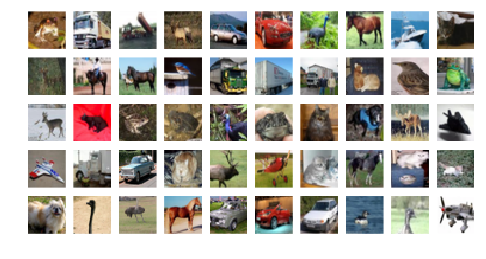

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8, 4))
for i in range(0, 50):
    plt.subplot(5, 10, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]), interpolation='none')

Import chainer and the dependencies.

In [9]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

Describe the neural net architecture you want to train.

In [10]:
! cat cnn.py
from cnn import CNN
model = CNN()

import chainer
import chainer.functions as F
import chainer.links as L

class CNN(chainer.Chain):

    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(3, 32, ksize=5, pad=2),
            conv2 = L.Convolution2D(32, 64, ksize=3, pad=1),
            conv3 = L.Convolution2D(64, 128, ksize=3, pad=1),
            conv4 = L.Convolution2D(128, 128, ksize=3, pad=1),
            fc5 = L.Linear(8192, 1024),
            fc6 = L.Linear(1024, 10),
        )

    def clear(self):
        self.loss = None
        self.accuracy = None

    def __call__(self, x, t, train=True):
        self.clear()
        y = self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

    def forward(self, x, train=False):
        self.h_input = x
        self.h_conv1 = F.relu(self.conv1(self.h_input))
        self.h_conv2 = F.relu(self.conv2(self.h_conv1))
        self.h_pool2 = F.max_pooli

Set the optimizer. (MomentumSGD, AdaDelta, AdaGrad, Adam, ...)

In [11]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))

If you use a gpu, set the gpu device value here.

In [12]:
gpuid = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpuid >= 0 else np

if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

Define the 'test_net' function to get the accuracy of the validation data.

In [13]:
import csv

log_train = open('cnn_train.log', 'w')
writer_train = csv.writer(log_train, lineterminator='\n')
writer_train.writerow(('iter', 'loss'))

log_test = open('cnn_test.log', 'w')
writer_test = csv.writer(log_test, lineterminator='\n')
writer_test.writerow(('iter', 'loss', 'acc'))

In [14]:
import sys
from tqdm import tqdm
batchsize = 100

def test(x, t):
    sum_accuracy = sum_loss = 0
    with tqdm(total=len(t)) as pbar:
        pbar.set_description('test')
        for i in range(0, len(t), batchsize):
            pbar.update(batchsize)
            x_batch = chainer.Variable(xp.asarray(x[i:i + batchsize]), volatile='on')
            t_batch = chainer.Variable(xp.asarray(t[i:i + batchsize]), volatile='on')
            loss = model(x_batch, t_batch, train=False)
            sum_loss += float(loss.data)
            sum_accuracy += float(model.accuracy.data)
    sys.stderr.flush()
    return sum_loss * batchsize / len(t), sum_accuracy * batchsize / len(t)

In [15]:
loss, acc = test(test_data, test_labels)
writer_test.writerow((0, loss, acc))
sys.stdout.write('test: loss={0:.6f}, accuracy={1:.6f}'.format(loss, acc))

test: 100%|██████████| 10000/10000 [00:00<00:00, 10754.97it/s]


test: loss=2.305007, accuracy=0.099600

We're going to train the model by using the training data `n_epoch` times.

In [16]:
n_epoch = 10
n_data = len(train_labels)

# Learning loop
for epoch in range(n_epoch):
    sys.stdout.write('(epoch: {})\n'.format(epoch + 1))
    sys.stdout.flush()
    
    # training
    perm = np.random.permutation(n_data)
    with tqdm(total=n_data) as pbar:
        for i in range(0, n_data, batchsize):
            it = epoch * n_data + i + batchsize
            x = chainer.Variable(xp.asarray(train_data[perm[i:i + batchsize]]), volatile='off')
            t = chainer.Variable(xp.asarray(train_labels[perm[i:i + batchsize]]), volatile='off')
            optimizer.update(model, x, t)
            loss = float(model.loss.data)
            writer_train.writerow((it, loss))
            pbar.set_description('train: loss={0:.6f}'.format(loss))
            pbar.update(batchsize)
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    writer_test.writerow((it, loss, acc))
    sys.stdout.write('test: loss={0:.6f}, accuracy={1:.6f}\n'.format(loss, acc))
    sys.stdout.flush()
    
# save model
model_filename = 'cnn-epoch{0:d}.chainermodel'.format(n_epoch)
serializers.save_hdf5(model_filename, model)

(epoch: 1)


test: 100%|██████████| 10000/10000 [00:00<00:00, 17519.89it/s]


test: loss=1.044976, accuracy=0.629600
(epoch: 2)


test: 100%|██████████| 10000/10000 [00:00<00:00, 17111.30it/s]


test: loss=0.830767, accuracy=0.711700
(epoch: 3)


test: 100%|██████████| 10000/10000 [00:00<00:00, 15941.32it/s]


test: loss=0.820290, accuracy=0.710100
(epoch: 4)


test: 100%|██████████| 10000/10000 [00:00<00:00, 18822.64it/s]


test: loss=0.722457, accuracy=0.749600
(epoch: 5)


test: 100%|██████████| 10000/10000 [00:00<00:00, 10032.03it/s]


test: loss=0.652265, accuracy=0.775600
(epoch: 6)


test: 100%|██████████| 10000/10000 [00:00<00:00, 10076.36it/s]


test: loss=0.667669, accuracy=0.766500
(epoch: 7)


test: 100%|██████████| 10000/10000 [00:01<00:00, 9980.79it/s]


test: loss=0.632305, accuracy=0.778400
(epoch: 8)


test: 100%|██████████| 10000/10000 [00:00<00:00, 10004.91it/s]


test: loss=0.627386, accuracy=0.787200
(epoch: 9)


test: 100%|██████████| 10000/10000 [00:01<00:00, 9981.14it/s]


test: loss=0.602823, accuracy=0.796900
(epoch: 10)


test: 100%|██████████| 10000/10000 [00:00<00:00, 10158.14it/s]


test: loss=0.666836, accuracy=0.779400


Plot the losses and the accuracies.

In [17]:
log_train.close()
log_test.close()
log_train = np.loadtxt('cnn_train.log', delimiter=',', skiprows=True).transpose()
log_test = np.loadtxt('cnn_test.log', delimiter=',', skiprows=True).transpose()

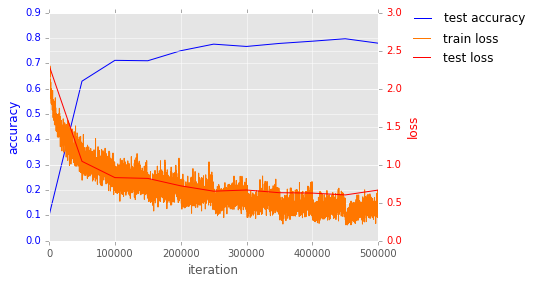

In [18]:
fig, ax1 = plt.subplots()
ax1.plot(log_test[0], log_test[2], 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color='b')
ax1.set_ylim(0, 0.9)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.48, 1.05), framealpha=0)
ax2 = ax1.twinx()
ax2.plot(log_train[0], log_train[1], color='#ff7700')
ax2.plot(log_test[0], log_test[1], 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.4, 0.96), framealpha=0)
plt.tight_layout()
plt.show()

Now we achieved 63% accuracy after epoch 1, and 79% accuracy after epoch 10 in the validation data. Let's classify one of the data.

In [19]:
def predict(x, top=5):
    x = x.reshape(1, 3, 32, 32)
    x_batch = chainer.Variable(xp.asarray(x),  volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = list(zip(y_batch.data[0], label_names))
    results.sort(reverse=True)
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:12s} | {2:7.3f}%'.format(rank, name, float(score*100)))

# 1| ship         |  67.495%
# 2| automobile   |  32.491%
# 3| airplane     |   0.013%
# 4| truck        |   0.001%
# 5| frog         |   0.000%


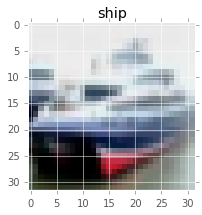

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(imdeprocess(test_data[1]), interpolation='none')
plt.title(label_names[test_labels[1]])
predict(test_data[1])

The 1st layer conv1 consist of 64 (3 color channels, 3x3 sized) filters.

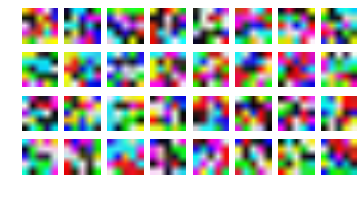

In [21]:
plt.figure(figsize=(6, 3))
for i in range(0, 32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    weights = model.conv1.W.data[i]
    if gpuid >= 0:
        weights = cuda.cupy.asnumpy(weights)
    plt.imshow(weights.transpose((1, 2, 0)))

The feature maps of conv1. They've extracted various features, e.g. edges and colors.

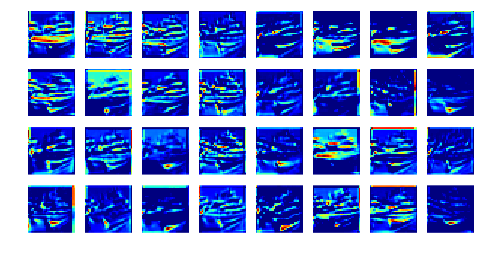

In [22]:
plt.figure(figsize=(8, 4))
for i in range(0, 32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    fmap = model.h_conv1.data[0][i]
    if gpuid >= 0:
        fmap = cuda.cupy.asnumpy(fmap)
    plt.imshow(fmap, interpolation='none')

The conv4 consist of 128 (128 channels, 3x3 sized) filters. We show only the first 16 channels of 16 filters.

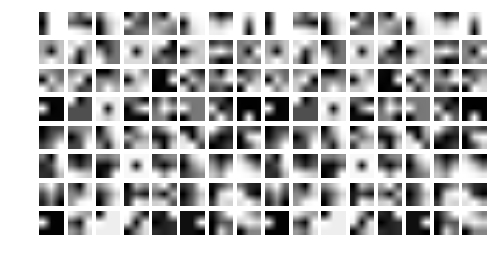

In [23]:
plt.figure(figsize=(8, 4))
for i in range(0, 16*8):
    plt.subplot(8, 16, i+1)
    plt.axis('off')
    weights = model.conv4.W.data[int(i/16)][i%8]
    if gpuid >= 0:
        weights = cuda.cupy.asnumpy(weights)
    plt.imshow(weights, cmap='gray')

The feature maps of conv4. We see the feature maps sparsely activated.

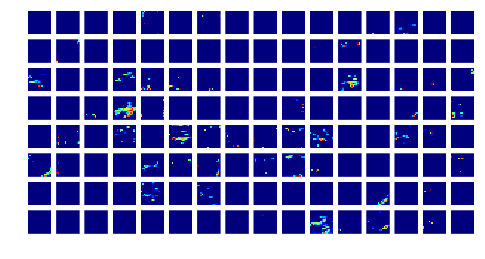

In [24]:
plt.figure(figsize=(8, 4))
for i in range(0, 128):
    plt.subplot(8, 16, i+1)
    plt.axis('off')
    fmap = model.h_conv4.data[0][i]
    if gpuid >= 0:
        fmap = cuda.cupy.asnumpy(fmap)
    plt.imshow(fmap, interpolation='none')